In [1]:
import json, os, sys
import numpy as np
import pandas as pd

pd.set_option('display.max_rows',100)

In [2]:
# connect with Google Drive and change to the folder with ATC 138 scripts
from google.colab import drive
drive.mount('/content/drive')

main_dir = '/content/drive/MyDrive/SimCenter/FunctionalRecovery/ATC138/'

os.chdir(main_dir)

Mounted at /content/drive


In [3]:
#model_name = 'RCSW_1story'
#model_name = 'haseltonRCMF_4story'
#model_name = 'haseltonRCMF_12story'
model_name = 'ICSB'

model_dir = f'./inputs/{model_name}/'

## Inputs

Each file listed below contains data specific to the building performance model and simulated damage given **for a specific level of shaking**. Each file listed will need to be created for each unique assessment and saved in the root directory of the build script. 

Data are contained in either json or csv format.

---
### Building Model

Provides general information about the building:

- **building_value**: [number] [USD]
<br> Total replacement value of the building
- **num_stories**: [number]
<br> number of stories in the building, does not include basement levels
- **total_area_sf**: [number] [ft2]
<br> total interior area of the entire building
- **area_per_story_sf**: [array] [ft2]
<br> interior area for each story in the building, starting from the lowest level
- **ht_per_story_ft**: [array] [ft2]
<br> elevation height for each story in the building, starting from the lowest level
- **edge_lengths**: [array] [ft]
<br> external length of two orthogonal sides of the building, for each story in the building, starting from the lowest level
- **struct_bay_area_per_story**: [array] [ft]
<br> length of the typical structural bay, from centerline to centerline, for each story in the building, starting from the lowest level
- **num_entry_doors**: [number]
<br> number of external building exits/entrances
- **num_elevators**: [number]
<br> number of elevator shafts in the building
- **stairs_per_story**: [array]
<br> number of stairways on each story in the building, starting from the lowest level
- **occupants_per_story**: [array]
<br> total number of occuapnts (persons) that occupy each story of this building, starting from the lowest level

In [4]:
with open(model_dir+'building_model.json') as f:
    building_model = json.load(f)
    
print(json.dumps(building_model, indent=2))

{
  "building_value": 15507252.123410186,
  "num_stories": 6,
  "total_area_sf": 56250,
  "area_per_story_sf": [
    9375,
    9375,
    9375,
    9375,
    9375,
    9375
  ],
  "ht_per_story_ft": [
    14.5,
    13.5,
    13.5,
    13.5,
    13.5,
    13.167
  ],
  "edge_lengths": [
    [
      96.82458365518542,
      96.82458365518542
    ],
    [
      96.82458365518542,
      96.82458365518542
    ],
    [
      96.82458365518542,
      96.82458365518542
    ],
    [
      96.82458365518542,
      96.82458365518542
    ],
    [
      96.82458365518542,
      96.82458365518542
    ],
    [
      96.82458365518542,
      96.82458365518542
    ]
  ],
  "struct_bay_area_per_story": [
    585.9375,
    585.9375,
    585.9375,
    585.9375,
    585.9375,
    585.9375
  ],
  "num_entry_doors": 2,
  "num_elevators": 2,
  "stairs_per_story": [
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "occupants_per_story": [
    37.5,
    37.5,
    37.5,
    37.5,
    37.5,
    37.5
  ]
}


---
### Tenant Units

Table that lists each tenant unit within the building; one row per tenant unit. This table requires the following attributes:

- **id**: [int or string] 
<br> unique identifier for this tenant unit
- **story**: [int] 
<br> building story where this tenant unit is located (ground floor is listed at 1)
- **area**: [float] [ft2]
<br> total gross plan area of the tenant unit
- **perim_area**: [float] [ft2] 
<br>total exterior perimeter area (elevation) of the tenant unit
- **occupancy_id**: [int] 
<br>foreign key to the occupancy_id attribute of the tenant_function_requirements.csv table in the static_tables directory

Other attributes listed in the input schema - I assume these have defaults:
- **exterior**: [float]
<br> tolerance for damage to exterior systems required for tenant function (0 = any damage causes loss of function, 0.999 = everything must be damage for loss of tenant function). Ratio of the perimeter area of severely damaged exterior components within the tenant-unit to the total perimeter area of the tenant unit (i.e., what percent of the exterior walls must be sufficiently damaged to cause tenants to not be able to function in this space).
- **interior**: [float]
<br> tolerance for damage to interior systems required for tenant function (0 = any damage causes loss of function, 0.999 = everything must be damage for loss of tenant function). Ratio of the interior plan area of severely damaged interior components within the tenant-unit to the total plan area of the tenant unit (i.e., what percent of the interior space must be hindered to cause tenants to not be able to function in this space).
- **occ_per_elev**: [float]
<br> max number of occupants per elevator allowed for function
- **is_elevator_required**: [bool]
<br> is an operational elevator required for tenant function
- **is_electrical_required**: [bool] 
<br> is an operational electrical system required for tenant function
- **is_water_required** [bool]
<br> is an operational plumbing system required for tenant function
- **is_hvac_required**: [bool] 
<br> is an operational hvac system required for tenant function

In [5]:
tenant_unit_list = pd.read_csv(model_dir+'tenant_unit_list.csv', header=0, index_col=0)

tenant_unit_list

,story,area,perim_area,occupancy_id
id,,,,
1,1,9375,4800,0
2,2,9375,4800,1
3,3,9375,4800,1
4,4,9375,4800,1
5,5,9375,4800,1
6,6,9375,4800,1


---
### Damage States

Table that lists each component and damage state populated in the building performance model; one row per each component's damage state. 

This table requires the following attributes:
- **comp_id**: [string] 
<br> unique FEMA P-58 component identifier
- **ds_seq_id**: [int] 
<br> integer index of the sequential parent damage state (i.e., damage state 1, 2, 3, 4)
- **ds_sub_id**: [int] 
<br> integer index for the mutually exlusive or simeltaneous sub damage state; use 1 to indicate a sequential damage state with no sub damage state.

In [6]:
damage_states = pd.read_csv(model_dir+'comp_ds_list.csv', header=0, index_col=0)

print(damage_states.shape)

damage_states

(93, 2)


,ds_seq_id,ds_sub_id
comp_id,,
B1041.021a,1,1
B1041.021a,2,1
B1041.021a,3,1
B1041.021a,3,2
B1041.021b,1,1
B1041.021b,2,1
B1041.021b,3,1
B1041.021b,3,2
B1041.111a,1,1


---
### Consequences

- **red_tag**: [array of bool]
<br> simulated logical of red tags, TRUE = building is red tagged
- **racked_stair_doors_per_story**: [array of int]
<br> simulated number of racked stairway doors per story
- **racked_entry_doors_side_1**: [array of int]
<br> simulated number of racked entry doors on one side of the building
- **racked_entry_doors_side_2**: [array of int]
<br> simulated number of racked entry doors on one side of the building
- **inpsection_trigger**: [array of bool]
<br> simulated logical of inspection triggers, TRUE = building requires inspection
- **repair_cost_ratio**: [array of float]
<br> simulated building repair cost normalized by the replacement value

In [7]:
with open(model_dir+'damage_consequences.json') as f:
    consequences = json.load(f)
    
for key, item in consequences.items():
    print(key, len(item))

red_tag 500
racked_stair_doors_per_story 500
racked_entry_doors_side_1 500
racked_entry_doors_side_2 500
inpsection_trigger 500
repair_cost_ratio 500


In [8]:
np.array(consequences['repair_cost_ratio']).mean()

0.2769175506912296

---
### Simulated Damage

Component-level simulated damage properties.

Contains a list of dictionaries, each dictionary corresponds to a tenant unit ("tu"). Within each dictionary, the following variables need to be defined:
- **qnt_damaged**: [array: simulations × damage states] 
<br>The number of damaged components in each component damage state for each realization of the simulation.
- **cost**: [array of float: sim x ds]
<br> simulated repair cost of each component's damage state
- **worker_days**: [array: simulations × damage states] 
<br>The number of single worker days required to repair all damage to this damage state of this component at this story for each realization.
- **qnt_damaged_side_1**: [array: simulations × damage states] 
<br>The number of damaged components in each component damage state assocaited with side 1 of the building; set to zero if not associated with a particular side. This is only for exterior cladding components.
- **qnt_damaged_side_2**: [array: simulations × damage states] 
<br>The number of damaged components in each component damage state assocaited with side 2 of the building; set to zero if not associated with a particular side. This is only for exterior cladding components.
- **qnt_damaged_side_3**: [array: simulations × damage states] 
<br>The number of damaged components in each component damage state assocaited with side 3 of the building; set to zero if not associated with a particular side. This is only for exterior cladding components.
- **qnt_damaged_side_4**: [array: simulations × damage states] 
<br>The number of damaged components in each component damage state associated with side 4 of the building; set to zero if not associated with a particular side. This is only for exterior cladding components.
- **num_comps**: [array: 1 × damage states] 
<br>The total number of components associated with each damage state (should be uniform for damage state of the same component stack).

In [9]:
with open(model_dir+'simulated_damage.json') as f:
    sim_dmg = json.load(f)
    
for key, item in sim_dmg[0].items():
    print(key, np.array(item).shape)

qnt_damaged (500, 93)
worker_days (500, 93)
qnt_damaged_side_1 (500, 93)
qnt_damaged_side_2 (500, 93)
qnt_damaged_side_3 (500, 93)
qnt_damaged_side_4 (500, 93)
num_comps (93,)


In [10]:
#pd.DataFrame(sim_dmg[0]['cost'])

---
### Optional Inputs

Details are described in the Inputs.json schema file

In [11]:
with open(model_dir+'optional_inputs.json') as f:
    options = json.load(f)
    
print(json.dumps(options, indent=2))

{
  "impedance_options": {
    "include_impedance": {
      "inspection": true,
      "financing": true,
      "permitting": true,
      "engineering": true,
      "contractor": true
    },
    "system_design_time": {
      "f": 0.04,
      "r": 175,
      "t": 1.3,
      "w": 8
    },
    "mitigation": {
      "is_essential_facility": false,
      "is_borp_equivalent": false,
      "is_engineer_on_retainer": false,
      "is_contractor_on_retainer": false,
      "funding_source": "private",
      "capital_available_ratio": 0.1
    },
    "impedance_beta": 0.6,
    "impedance_truncation": 2
  },
  "repair_time_options": {
    "temp_repair_beta": 0.6,
    "max_workers_per_sqft_story": 0.001,
    "max_workers_per_sqft_building": 0.00025,
    "max_workers_building_min": 20,
    "max_workers_building_max": 260
  },
  "functionality_options": {
    "door_racking_repair_day": 3,
    "egress_threshold": 0.5,
    "egress_threshold_wo_fs": 0.75,
    "required_ratio_operating_hvac_main": 0.6667,

## Analysis

In [12]:
from inputs.Inputs2Copy.build_input import build_input
from driver_PBEErecovery import run_analysis
os.chdir(main_dir)

In [13]:
%reload_ext autoreload
%autoreload 2

os.chdir(model_dir)
build_input('simulated_inputs.json')
os.chdir(main_dir)

/content/drive/MyDrive/SimCenter/FunctionalRecovery/ATC138/inputs/ICSB
Component ID B1041.021a does not belong to a subsystem
Component ID B1041.021a does not belong to a subsystem
Component ID B1041.021a does not belong to a subsystem
Component ID B1041.021a does not belong to a subsystem
Component ID B1041.021b does not belong to a subsystem
Component ID B1041.021b does not belong to a subsystem
Component ID B1041.021b does not belong to a subsystem
Component ID B1041.021b does not belong to a subsystem
Component ID B1041.111a does not belong to a subsystem
Component ID B1041.111a does not belong to a subsystem
Component ID B1041.111a does not belong to a subsystem
Component ID B1041.111b does not belong to a subsystem
Component ID B1041.111b does not belong to a subsystem
Component ID B1041.111b does not belong to a subsystem
Component ID B1041.121b does not belong to a subsystem
Component ID B1041.121b does not belong to a subsystem
Component ID B1044.003 does not belong to a subsy

In [14]:
%reload_ext autoreload
%autoreload 2

run_analysis(model_name)

time to run 8.95s


## Outputs

In [15]:
with open(f'./outputs/{model_name}/recovery_outputs.json') as f:
    outputs = json.load(f)
    
for key, item in outputs.items():
    print(key, np.array(item).shape)

utilities ()
impeding_factors ()
worker_data ()
building_repair_schedule ()
recovery ()


In [16]:
from plotModel_PBEErecovery import plot_results

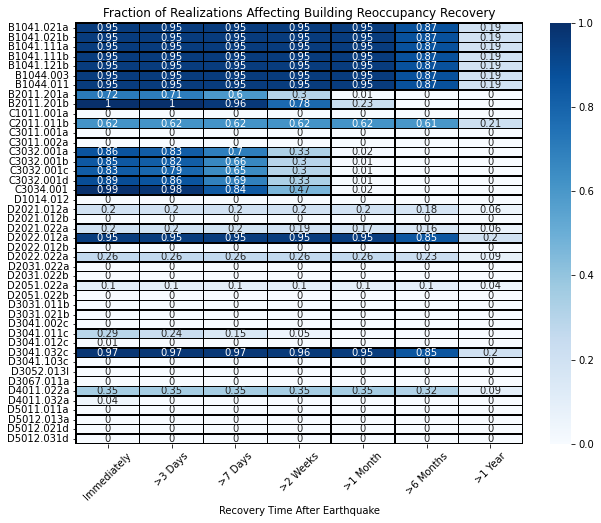

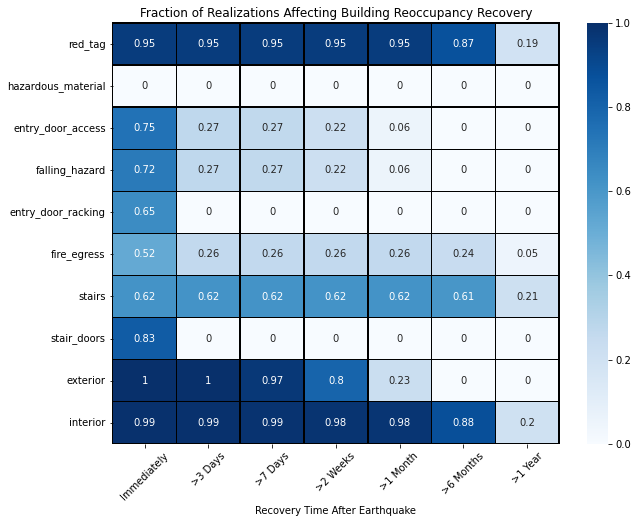

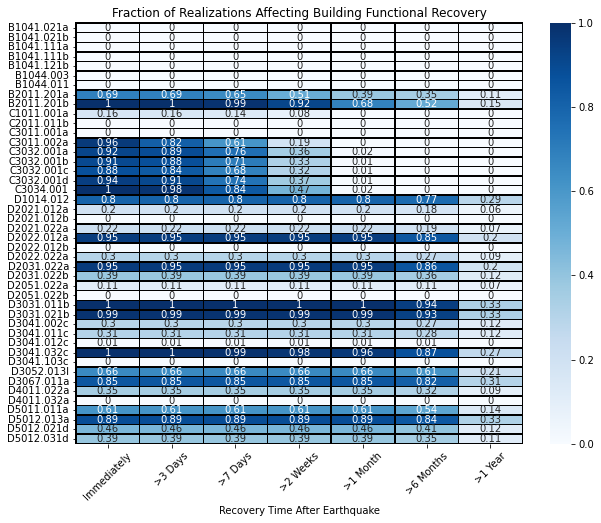

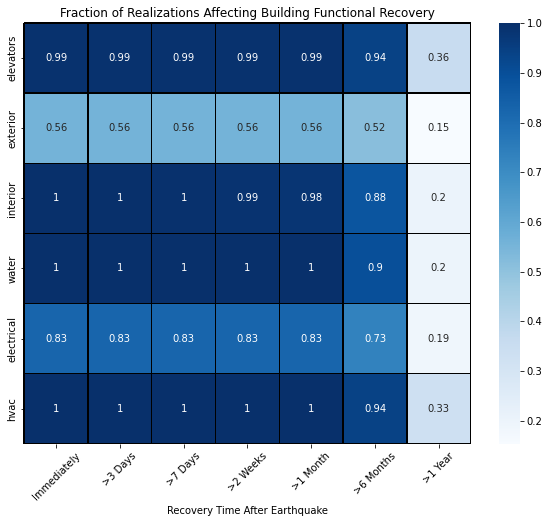

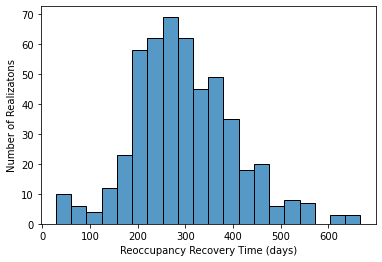

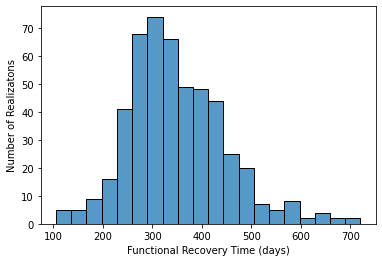

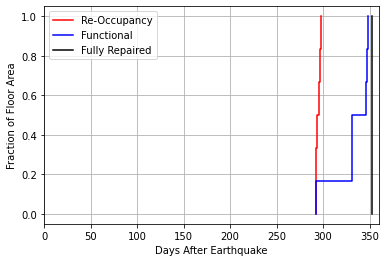

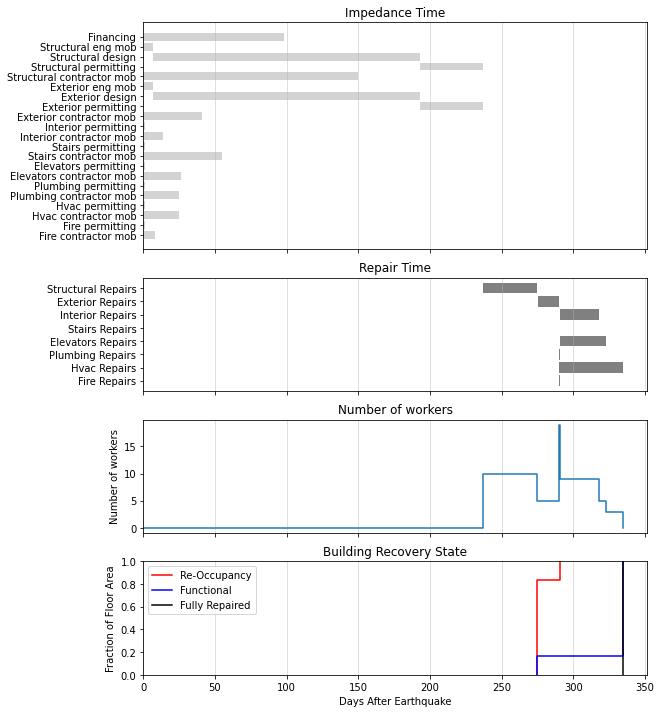

In [17]:
%reload_ext autoreload
%autoreload 2

plot_results(model_name)